In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

import os
os.chdir("../")

from epitools import get_data

In [2]:
year = 2020
candidates = ["AL GORE", "GEORGE W. BUSH"]

In [3]:
output = []
for year in [2008, 2012, 2016, 2020]:
    df = pd.read_csv(
    f"data_output/United States/{year}_first_round.csv.gz",
    compression="gzip"
    )

    df_location = pd.read_csv(
        f"data_output/United States/{year}_first_round_location.csv.gz",
        compression="gzip"
    )

    df = pd.merge(df, df_location, on="polling_id")
    df_tmp = df.groupby(["state", "candidate"]).agg({"value": "sum"}).sort_values(["state", "value"], ascending=(True, False))
    df_tmp["rank"] = df_tmp.groupby(["state"]).cumcount() + 1
    df_tmp["year"] = year
    df_tmp = df_tmp.reset_index()
    df_tmp = df_tmp[df_tmp["rank"] == 1]
    df_tmp["candidate"] = df_tmp["candidate"].replace({
        "GEORGE W. BUSH": "REPUBLICAN",
        "AL GORE": "DEMOCRAT",
        "JOHN KERRY": "DEMOCRAT",
        "BARACK OBAMA": "DEMOCRAT",
        "JOHN MCCAIN": "REPUBLICAN",
        "MITT ROMNEY": "REPUBLICAN",
        "HILLARY CLINTON": "DEMOCRAT",
        "DONALD TRUMP": "REPUBLICAN",
        "DONALD J TRUMP": "REPUBLICAN",
        "JOSEPH R BIDEN JR": "DEMOCRAT"
    })

    output.append(df_tmp)

In [4]:
df = pd.concat(output, ignore_index=True)
df

,state,candidate,value,rank,year
0,ALABAMA,REPUBLICAN,1266546,1,2008
1,ALASKA,REPUBLICAN,193841,1,2008
2,ARIZONA,REPUBLICAN,1230111,1,2008
3,ARKANSAS,REPUBLICAN,638017,1,2008
4,CALIFORNIA,DEMOCRAT,8274473,1,2008
...,...,...,...,...,...
199,VIRGINIA,DEMOCRAT,2413568,1,2020
200,WASHINGTON,DEMOCRAT,2369612,1,2020
201,WEST VIRGINIA,REPUBLICAN,545382,1,2020
202,WISCONSIN,DEMOCRAT,1630673,1,2020


In [5]:
dd = df.groupby(["state", "candidate"]).agg({"value": "count"}).reset_index()\
    .pivot(index="state", columns="candidate", values="value").fillna(0)

dd["diff"] = (dd["DEMOCRAT"] - dd["REPUBLICAN"])
dd = dd.reset_index()
df_purple = dd.sort_values("diff")

# df_purple["type"] = df_purple["diff"].apply(lambda x: "SWING" if (x <= 2 and x>=-2) else\
    # "DEMOCRAT" if (x > 2) else "REPUBLIC")

df_purple["type"] = df_purple["diff"].apply(lambda x: "SWING" if (x <= 2 and x>=-2) else "PARTISAN")

# df_purple = pd.DataFrame(dd[dd["diff"] <= 2]["state"].unique(), columns=["state"])
# df_purple["is_purple"] = 1
df_purple.head()

candidate,state,DEMOCRAT,REPUBLICAN,diff,type
0,ALABAMA,0.0,4.0,-4.0,PARTISAN
48,WEST VIRGINIA,0.0,4.0,-4.0,PARTISAN
44,UTAH,0.0,4.0,-4.0,PARTISAN
43,TEXAS,0.0,4.0,-4.0,PARTISAN
42,TENNESSEE,0.0,4.0,-4.0,PARTISAN


In [6]:
df_purple[["state", "type"]].to_csv("States_Type_United_States.csv", index=False)

In [7]:
df_purple[df_purple["type"] == "Purple"]["state"].unique()


array([], dtype=object)

In [8]:
output = []
method = "nv"

for year in [2000, 2004, 2008, 2012, 2016, 2020]:
    df_tmp = get_data(
        country="United States",
        aggregation="state",
        election="first_round",
        year=year
    )
    output.append(df_tmp)

df_dv = pd.concat(output, ignore_index=True)
df_dv = df_dv.rename(columns={"epi": "value"})
df_dv["state"] = df_dv["state"].str.upper()

df_dv = pd.merge(df_dv, df_purple, on="state", how="outer")
# df_dv["is_purple"] = df_dv["is_purple"].fillna(0)
df_dv = df_dv[df_dv["state"] != "DISTRICT OF COLUMBIA"]
df_dv.head()

,state,value,epi_between,epi_within,year,DEMOCRAT,REPUBLICAN,diff,type
0,ALABAMA,0.954538,0.812398,0.142140,2000,0.0,4.0,-4.0,PARTISAN
1,ALABAMA,0.898169,0.722451,0.175718,2004,0.0,4.0,-4.0,PARTISAN
2,ALABAMA,0.954042,0.720001,0.234042,2008,0.0,4.0,-4.0,PARTISAN
3,ALABAMA,0.949574,0.702386,0.247188,2012,0.0,4.0,-4.0,PARTISAN
4,ALABAMA,0.935563,0.653429,0.282135,2016,0.0,4.0,-4.0,PARTISAN


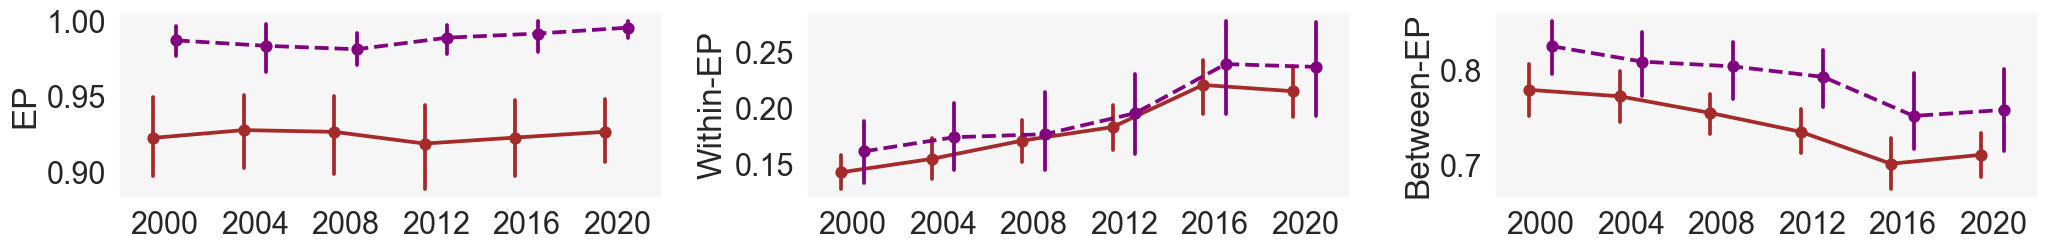

In [10]:
sns.set(font_scale=2, rc={"axes.facecolor": "#f6f6f6", "axes.grid" : False})
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(21, 3))

sns.pointplot(x="year", y="value", linestyles=["-", "--", "-."], hue="type", dodge=0.25, ax=axs[0], palette=["brown", "purple", "blue"], data=df_dv)
axs[0].set_ylabel("EP")
sns.pointplot(x="year", y="epi_within", linestyles=["-", "--", "-."], hue="type", dodge=0.25, ax=axs[1], palette=["brown", "purple", "blue"], data=df_dv)
axs[1].set_ylabel("Within-EP")
sns.pointplot(x="year", y="epi_between", linestyles=["-", "--", "-."], hue="type", dodge=0.25, ax=axs[2], palette=["brown", "purple", "blue"], data=df_dv)
axs[2].set_ylabel("Between-EP")

for i in range(3):
    axs[i].set_xlabel("")
    leg = axs[i].legend()
    leg.remove()

fig.tight_layout()

Overall, we find that Swing states performed more polarized elections than Partisan states. Nevertheless, the difference is slighly significant only for Between-EP. This result is relevant since provides evidence that our method identified first that Swing states are more polarized than partisans ones, and second emphasizing that these differences are mainly explained by the competitiveness rather in geographical divisions, as suggested in the literature (REFs).
